# System dynamics when both the weights and activity evolve

Using Oja's rule the weights should always converge to have an L2 norm of 1.

Our derivation involved integrating over a period of rotating activity before making a weight update, so we sum weight updates over each period before just applying the weight update at the end. If we make the weights dynamic during each timestep of the period, the simulations are more unstable. We use this simplification based on the assumption that the dynamics of the weights are generally much slower than the dynamics of the activity.

In [1]:
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
import scipy.linalg
import matplotlib.scale
plt.style.use('seaborn-v0_8-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [8,6]) # paper figures should be width 8 (full linewidth) to have nicely readable text

In [2]:
profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_spectrum = lambda fourier_spectrum: np.fft.ifft(fourier_spectrum).real
circular_concat = lambda x : np.hstack((x, x[0]))

def fill_fourier_modes_up_to_N(last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements up to the `last_fourier_mode` filled with ones.
	
	`last_fourier_mode=0` corresponds to just the DC component being filled.
	
	For higher Fourier modes both the positive and negative frequency components are filled.
	
	eg. `fill_fourier_modes_up_to_N(1, 4) = [1,1,0,1]`
	'''
	assert last_fourier_mode <= period//2, f'last fourier mode of {last_fourier_mode} not possible with discrete Fourier vector of length {period}'
	half_fourier_vector = np.zeros(period//2+1)
	half_fourier_vector[:last_fourier_mode+1] = 1
	return np.hstack((half_fourier_vector, np.flip(half_fourier_vector[1:-1])))

def fill_fourier_modes_in_range(first_fourier_mode:int, last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements between `first_fourier_mode` and `last_fourier_mode` (inclusive) filled with ones, with other Fourier modes = 0.
	
	eg. `fill_fourier_modes_in_range(1, 2, 4) = [0,1,1,1]`
	'''
	fourier_spectrum = (fill_fourier_modes_up_to_N(last_fourier_mode, period) - fill_fourier_modes_up_to_N(first_fourier_mode-1, period))
	return fourier_spectrum

def roll_matrix_rows(matrix, roll_amounts):
	'''roll each row of a 2D matrix by an independent amount, as specified in `roll_amounts`.'''
	matrix_rolled = matrix[:, [*range(matrix.shape[1]),*range(matrix.shape[1]-1)]].copy()
	stride_0, stride_1 = matrix_rolled.strides
	num_cols = matrix.shape[1]
	result = numpy.lib.stride_tricks.as_strided(matrix_rolled, (*matrix.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[np.arange(matrix.shape[0]), (num_cols-roll_amounts) % num_cols]

N = 8
neuron_indices = np.arange(N)

In [3]:
def get_circulant_matrix_profile(matrix):
	N = np.arange(matrix.shape[0])
	unrolled_matrix = roll_matrix_rows(matrix, -N)

	mu = unrolled_matrix.mean(axis=0)
	stddev = np.sqrt(unrolled_matrix.var(axis=0))

	return mu, stddev

def plot_circulant_matrix_as_profile(matrix, plot_stddev=True, roll=False, show=True):
	N = np.arange(matrix.shape[0]+1)
	mu, stddev = get_circulant_matrix_profile(matrix)
	if roll:
		N -= matrix.shape[0]//2
		mu = np.roll(mu, matrix.shape[0]//2)
		stddev = np.roll(stddev, matrix.shape[0]//2)

	plt.plot(N, circular_concat(mu), 'o--', markersize=6, linewidth=1)
	if plot_stddev:
		plt.fill_between(N, circular_concat(mu-stddev), circular_concat(mu+stddev), alpha=0.2)
	if show:
		plt.show()

def profile_to_mu_amp_phase(profile):
	# using vector population code readout
	# first remove the mean, then array the profile around a circle and find the angle and vector magnitude
	# for a sinusoid of amplitude 1, the total length will be 4 (2 + 4(sqrt(2)/2)^2), so normalise by this
	N = len(profile)
	mu = profile.mean()
	x = np.sum((profile - mu) * np.cos(2*np.pi*np.arange(len(profile))/len(profile)))
	y = np.sum((profile - mu) * np.sin(2*np.pi*np.arange(len(profile))/len(profile)))
	return mu, np.sqrt(x**2 + y**2)/4, np.arctan2(y, x)/2/np.pi*N

def simulate_dynamic_weights_and_activity(W, W0, a0, input, dt=0.01, eta=0.1, period=N):
	grad_W_accumulated = np.zeros_like(W)
	a = a0.copy()
	a_trace = []
	W_trace = []
	W_rms_trace = []
	for t in range(input.shape[0]):
		grad_W = a.reshape(N,1) @ a.reshape(1,N) - N/2*a.reshape(1,N)**2*W
		grad_a = - a + W@a + input[t,:]
		a += dt*grad_a
		grad_W_accumulated += grad_W
		if np.any(np.isnan(grad_W)) or np.any(np.isnan(grad_a)):
			break
		if (t+1) % period == 0:
			W += eta*dt*grad_W_accumulated
			grad_W_accumulated = 0
			W_rms_trace.append(np.sqrt(np.mean((W0 - W)**2)))
			W_trace.append(W.copy())
		a_trace.append(a.copy())
	return W, a, a_trace, W_trace, W_rms_trace

## Linear neurons
### Simulation with zero initial weights

* initial weights are zero
* initial activity is noisy sinusoid
* input activity is noisy sinusoid

In [4]:
dt=0.01
eta=0.1
f=1
W0_clean = 2/N * profile_to_matrix(np.cos(2*f*np.pi*neuron_indices/N))
noise_sigma_a = 0.2
noise_sigma_input = 0.2
W0_fromzero = 0*W0_clean
a0_clean = np.cos(2*f*np.pi*neuron_indices/N)
a0 = 1*a0_clean + noise_sigma_a*np.random.randn(N)

neuron_directions = np.arange(N) / f
input_speed = 1/8
one_period_length = int(N/input_speed)
input_steps = np.arange(0, N, input_speed)
periods = 100
input_offset = np.pi/2
input_scale = np.sqrt(2 - 2*np.cos(np.pi/(N/2/input_speed)))
input = 1/dt* input_scale * np.tile(np.cos(2*f*np.pi*input_steps.reshape(1,-1)/N - 2*f*np.pi*neuron_directions.reshape(N,1)/N + input_offset).T, (periods,1))
input += noise_sigma_input*np.random.randn(*input.shape)

W_fromzero, a_fromzero, a_trace_fromzero, W_trace_fromzero, W_rms_trace_fromzero = simulate_dynamic_weights_and_activity(W0_fromzero.copy(), W0_clean, a0.copy(), input, dt, eta, one_period_length)

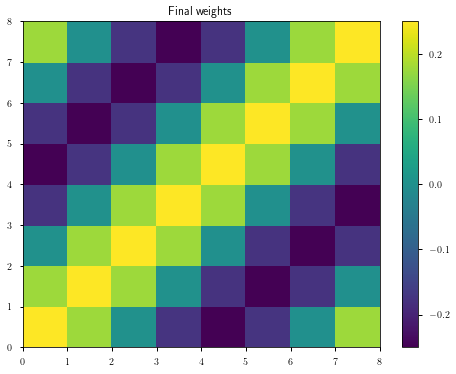

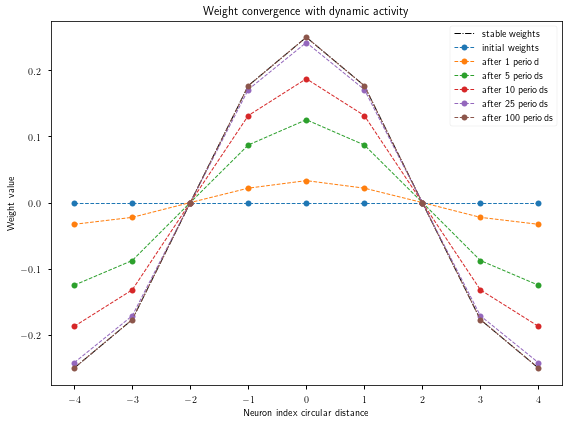

Weight Errors: RMS before = 0.177, RMS after = 0.001


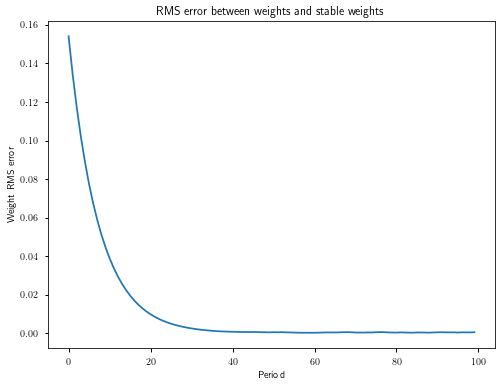

Activity Error: RMS before = 0.186, RMS after = 0.084


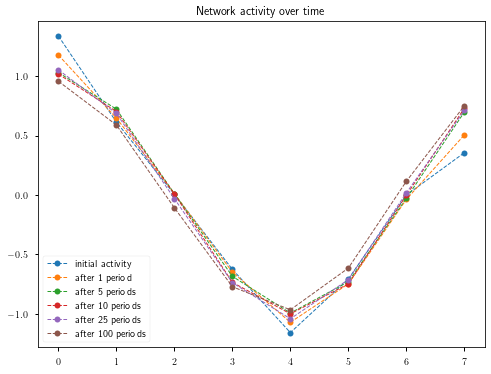

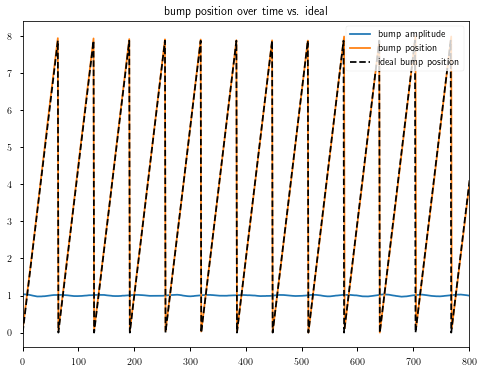

In [5]:
plt.pcolor(W_fromzero)
plt.colorbar()
plt.title('Final weights')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, 1, N)), N//2)), 'k-.', linewidth=1)
plot_circulant_matrix_as_profile(W0_fromzero, plot_stddev=False, roll=True, show=False)
periods_to_plot = [1,5,10,25,100]
for period in periods_to_plot:
	plot_circulant_matrix_as_profile(W_trace_fromzero[period-1], plot_stddev=False, roll=True, show=False)
plt.legend(['stable weights','initial weights'] + [f'after {period} period{"s" if period>1 else ""}' for period in periods_to_plot])
plt.xlabel('Neuron index circular distance')
plt.ylabel('Weight value')
plt.title('Weight convergence with dynamic activity')
plt.tight_layout()
plt.show()

print(f'Weight Errors: RMS before = {np.sqrt(np.mean((W0_fromzero - W0_clean)**2)):.3f}, RMS after = {np.sqrt(np.mean((W_fromzero - W0_clean)**2)):.3f}')
plt.plot(W_rms_trace_fromzero)
plt.xlabel('Period')
plt.ylabel('Weight RMS error')
plt.title('RMS error between weights and stable weights')
plt.show()

plt.plot(a0, 'o--', markersize=6, linewidth=1)
for period in periods_to_plot:
	plt.plot(a_trace_fromzero[period*one_period_length-1], 'o--', markersize=6, linewidth=1)
plt.legend(['initial activity'] + [f'after {period} period{"s" if period>1 else ""}' for period in periods_to_plot])
print(f'Activity Error: RMS before = {np.sqrt(np.mean((a0 - a0_clean)**2)):.3f}, RMS after = {np.sqrt(np.mean((a_fromzero - a0_clean)**2)):.3f}')
plt.title('Network activity over time')
plt.show()

plt.plot([profile_to_mu_amp_phase(a)[1] for a in [a0] + a_trace_fromzero], label='bump amplitude')
plt.plot([profile_to_mu_amp_phase(a)[2] % N for a in [a0] + a_trace_fromzero], label='bump position')
plt.plot((np.arange(len(a_trace_fromzero)) * input_speed) % N, 'k--', label='ideal bump position')
plt.title('bump position over time vs. ideal')
plt.xlim(0, 800)
plt.legend()
plt.show()

The weights converge from zero to the sinusoidal weights that are required to make the network activity update stable

### Simulation with noisy sinusoidal initial weights

* initial weights are noisy sinusoid
* initial activity is noisy sinusoid
* input activity is noisy sinusoid

In [6]:
noise_sigma_W = 0.2
noise_sigma_a = 0.2
noise_sigma_input = 0.2
W0_fromnoisy = 1*W0_clean + noise_sigma_W*np.random.randn(N,N)
a0_clean = np.cos(2*f*np.pi*neuron_indices/N)
a0 = 1*a0_clean + noise_sigma_a*np.random.randn(N)

neuron_directions = np.arange(N) / f
input_speed = 1/8
one_period_length = int(N/input_speed)
input_steps = np.arange(0, N, input_speed)
periods = 100
input_offset = np.pi/2
input_scale = np.sqrt(2 - 2*np.cos(np.pi/(N/2/input_speed)))
input = 1/dt* input_scale * np.tile(np.cos(2*f*np.pi*input_steps.reshape(1,-1)/N - 2*f*np.pi*neuron_directions.reshape(N,1)/N + input_offset).T, (periods,1))
input += noise_sigma_input*np.random.randn(*input.shape)

W_fromnoisy, a_fromnoisy, a_trace_fromnoisy, W_trace_fromnoisy, W_rms_trace_fromnoisy = simulate_dynamic_weights_and_activity(W0_fromnoisy.copy(), W0_clean, a0.copy(), input, dt, eta, one_period_length)

### Plot both cases together

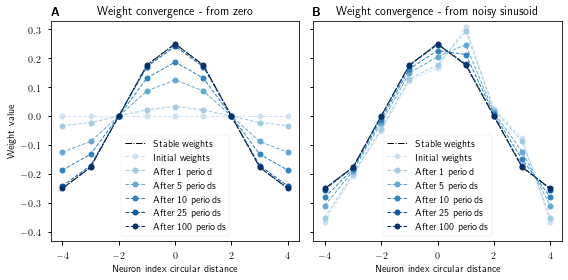

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), sharey=True)
axs[0].set_prop_cycle(plt.cycler(color = plt.cm.Blues(np.linspace(0.2, 1, 6))))
axs[1].set_prop_cycle(plt.cycler(color = plt.cm.Blues(np.linspace(0.2, 1, 6))))
plt.sca(axs[0])
plt.plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, 1, N)), N//2)), 'k-.', linewidth=1)
plot_circulant_matrix_as_profile(W0_fromzero, plot_stddev=False, roll=True, show=False)
periods_to_plot = [1,5,10,25,100]
for period in periods_to_plot:
	plot_circulant_matrix_as_profile(W_trace_fromzero[period-1], plot_stddev=False, roll=True, show=False)
plt.legend(['Stable weights','Initial weights'] + [f'After {period} period{"s" if period>1 else ""}' for period in periods_to_plot])
plt.xlabel('Neuron index circular distance')
plt.ylabel('Weight value')
plt.title('Weight convergence - from zero')
plt.title('$\\textbf{A}$', loc='left')

plt.sca(axs[1])
plt.plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, 1, N)), N//2)), 'k-.', linewidth=1)
plot_circulant_matrix_as_profile(W0_fromnoisy, plot_stddev=False, roll=True, show=False)
for period in periods_to_plot:
	plot_circulant_matrix_as_profile(W_trace_fromnoisy[period-1], plot_stddev=False, roll=True, show=False)
plt.legend(['Stable weights','Initial weights'] + [f'After {period} period{"s" if period>1 else ""}' for period in periods_to_plot])
plt.xlabel('Neuron index circular distance')
plt.title('Weight convergence - from noisy sinusoid')
plt.title('$\\textbf{B}$', loc='left')
plt.ylim(-0.43, 0.33)

plt.tight_layout()
plt.savefig('plots/ojas-rule-dynamic-activity-weight-convergence-both.pdf')
plt.show()

## Nonlinear neurons with distorted (more square wave) input

Now the neurons have a $\tanh$ activation function

$$\dot{\mathbf{a}} = -\mathbf{a} + \phi[\mathbf{W}\mathbf{a} + \mathbf{u}(t)]$$

where $\phi(x) = \tanh(x)$

We also distort the input that is provided to the network so it is no longer a noisy pure sinusoid but instead more of a square wave shape.

Because the tanh activation function reduces the activity level in the network ($|\tanh(x)| < |x|~\forall x$) this reduces the rate of weight updates because they are proportional to the amount of activity in the network. We therefore need to run these simulations for longer to see weight convergence.

In [8]:
def nonlinearity(activity):
	return np.tanh(activity)

def simulate_dynamic_weights_and_activity_nonlinear(W, W0, a0, input, dt=0.01, eta=0.1, period=N):
	grad_W_accumulated = np.zeros_like(W)
	a = a0.copy()
	a_trace = []
	W_trace = []
	W_rms_trace = []
	for t in range(input.shape[0]):
		grad_W = a.reshape(N,1) @ a.reshape(1,N) - N/2*a.reshape(1,N)**2*W
		grad_a = - a + nonlinearity(W@a + input[t,:])
		a += dt*grad_a
		grad_W_accumulated += grad_W
		if np.any(np.isnan(grad_W)) or np.any(np.isnan(grad_a)):
			break
		if (t+1) % period == 0:
			W += eta*dt*grad_W_accumulated
			grad_W_accumulated = 0
			W_rms_trace.append(np.sqrt(np.mean((W0 - W)**2)))
			W_trace.append(W.copy())
		a_trace.append(a.copy())
	return W, a, a_trace, W_trace, W_rms_trace

noise_sigma_W = 0.2
noise_sigma_a = 0.2
noise_sigma_input = 0.2
W0_nonlinear_fromzero = 0*W0_clean# + noise_sigma_W*np.random.randn(N,N)
W0_nonlinear_fromnoisy = 1*W0_clean + noise_sigma_W*np.random.randn(N,N)
a0_clean = np.cos(2*f*np.pi*neuron_indices/N)
a0 = 1*a0_clean + noise_sigma_a*np.random.randn(N)

neuron_directions = np.arange(N) / f
input_speed = 1/8
one_period_length = int(N/input_speed)
input_steps = np.arange(0, N, input_speed)
periods = 2500
input_offset = np.pi/2
input_scale = np.sqrt(2 - 2*np.cos(np.pi/(N/2/input_speed)))
base_input = np.tile(np.cos(2*f*np.pi*input_steps.reshape(1,-1)/N - 2*f*np.pi*neuron_directions.reshape(N,1)/N + input_offset).T, (periods,1))
distorted_input = np.tanh(2*base_input) # make the input more square than a true sinusoid
input = 1/dt* input_scale * distorted_input
input += noise_sigma_input*np.random.randn(*input.shape)

W_nonlinear_fromzero, a_nonlinear_fromzero, a_trace_nonlinear_fromzero, W_trace_nonlinear_fromzero, W_rms_trace_nonlinear_fromzero = simulate_dynamic_weights_and_activity_nonlinear(W0_nonlinear_fromzero.copy(), W0_clean, a0.copy(), input, dt, eta, one_period_length)
W_nonlinear_fromnoisy, a_nonlinear_fromnoisy, a_trace_nonlinear_fromnoisy, W_trace_nonlinear_fromnoisy, W_rms_trace_nonlinear_fromnoisy = simulate_dynamic_weights_and_activity_nonlinear(W0_nonlinear_fromnoisy.copy(), W0_clean, a0.copy(), input, dt, eta, one_period_length)

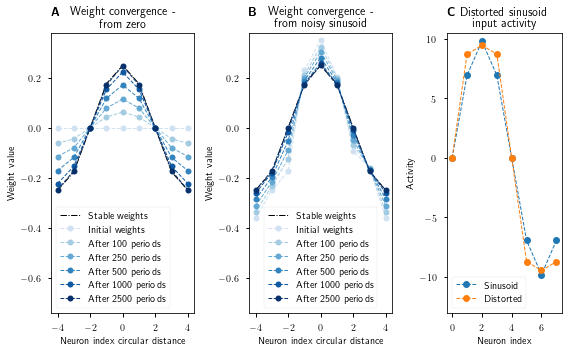

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(8,5), sharey=False, gridspec_kw={'width_ratios': [2,2,1.6]})
axs[0].set_prop_cycle(plt.cycler(color = plt.cm.Blues(np.linspace(0.2, 1, 6))))
axs[1].set_prop_cycle(plt.cycler(color = plt.cm.Blues(np.linspace(0.2, 1, 6))))
axs[1].sharey(axs[0])
plt.sca(axs[0])
plt.plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, 1, N)), N//2)), 'k-.', linewidth=1)
plot_circulant_matrix_as_profile(W0_nonlinear_fromzero, plot_stddev=False, roll=True, show=False)
periods_to_plot = [100,250,500,1000,2500]
for period in periods_to_plot:
	plot_circulant_matrix_as_profile(W_trace_nonlinear_fromzero[period-1], plot_stddev=False, roll=True, show=False)
plt.legend(['Stable weights','Initial weights'] + [f'After {period} period{"s" if period>1 else ""}' for period in periods_to_plot])
plt.xlabel('Neuron index circular distance')
plt.ylabel('Weight value')
plt.title('Weight convergence -\nfrom zero')
plt.title('$\\textbf{A}$\n', loc='left')
plt.xticks(range(-4,5,2))

plt.sca(axs[1])
plt.plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, 1, N)), N//2)), 'k-.', linewidth=1)
plot_circulant_matrix_as_profile(W0_nonlinear_fromnoisy, plot_stddev=False, roll=True, show=False)
for period in periods_to_plot:
	plot_circulant_matrix_as_profile(W_trace_nonlinear_fromnoisy[period-1], plot_stddev=False, roll=True, show=False)
plt.legend(['Stable weights','Initial weights'] + [f'After {period} period{"s" if period>1 else ""}' for period in periods_to_plot])
plt.xlabel('Neuron index circular distance')
plt.ylabel('Weight value')
plt.title('Weight convergence -\nfrom noisy sinusoid')
plt.title('$\\textbf{B}$\n', loc='left')
# plt.yticks([])
plt.ylim(-0.74, 0.38)
plt.xticks(range(-4,5,2))

plt.sca(axs[2])
plt.plot(1/dt* input_scale * base_input[0], '--o', linewidth=1, label="Sinusoid")
plt.plot(1/dt* input_scale * distorted_input[0], '--o', linewidth=1, label="Distorted")
plt.title('Distorted sinusoid\ninput activity')
plt.title('$\\textbf{C}$\n', loc='left')
plt.ylabel('Activity')
plt.xlabel('Neuron index')
plt.ylim(-13, 10.5)
plt.legend()
plt.xticks(range(0,8,2))

plt.tight_layout()
plt.savefig('plots/ojas-rule-nonlinear-neurons-both.pdf')
plt.show()

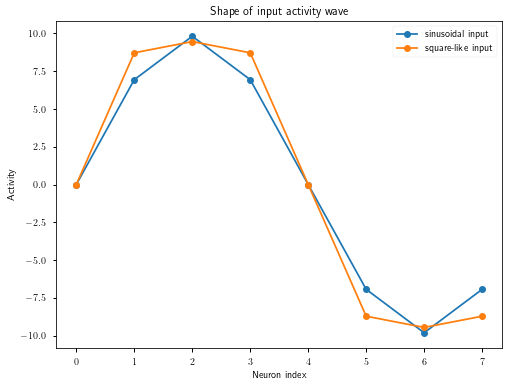

In [10]:
plt.plot(1/dt* input_scale * base_input[0], '-o', label="sinusoidal input")
plt.plot(1/dt* input_scale * distorted_input[0], '-o', label="square-like input")
# plt.plot(input[0], label="with noise")
plt.title('Shape of input activity wave')
plt.ylabel('Activity')
plt.xlabel('Neuron index')
plt.legend()
plt.show()